#DATA ANALYSIS AND VISUALIZATION FOR TRANSBORDER FREIGHT SYSTEM

##LOADING AND MERGING DATA



In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
import seaborn as sns
from glob import glob



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_path = "/content/drive/MyDrive/TMP/TMP_TransBorder_Freight_Analysis_Data"


In [4]:
# load all CSV files from the nested year/month folders
csv_files = glob(os.path.join(data_path, '**/*.csv'), recursive=True)
print(f"Found {len(csv_files)} CSV files.")

Found 296 CSV files.


In [5]:
sample_file = csv_files[0]

In [6]:
sample_df = pd.read_csv(sample_file, encoding='latin1', nrows=5)  # Load a few rows
print(sample_df.columns.tolist())
print(sample_df.head())

['TRDTYPE', 'DEPE', 'COMMODITY2', 'DISAGMOT', 'COUNTRY', 'VALUE', 'SHIPWT', 'FREIGHT_CHARGES', 'DF', 'CONTCODE', 'MONTH', 'YEAR']
   TRDTYPE  DEPE  COMMODITY2  DISAGMOT  COUNTRY   VALUE  SHIPWT  \
0        1   101           5         5     1220   27500       0   
1        1   101          12         5     1220    8576       0   
2        1   101          19         5     1220   41359       0   
3        1   101          25         5     1220   14615       0   
4        1   101          29         5     1220  119860       0   

   FREIGHT_CHARGES  DF CONTCODE  MONTH  YEAR  
0              539   2        X      1  2022  
1              167   1        X      1  2022  
2              810   1        X      1  2022  
3              286   1        X      1  2022  
4             2047   1        X      1  2022  


In [7]:
#merge csv files
dfs = []
for file in csv_files:
    df = pd.read_csv(file, encoding='latin1', low_memory=False, dtype={
    'COUNTRY': str,
    'YEAR': str  # Load as string first to avoid dtype warning
})
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

In [8]:
print(f"Merged shape: {df.shape}")
print(df.head())

Merged shape: (36347182, 15)
   TRDTYPE  DEPE  COMMODITY2  DISAGMOT COUNTRY   VALUE  SHIPWT  \
0        1  0101         5.0         5    1220   27500       0   
1        1  0101        12.0         5    1220    8576       0   
2        1  0101        19.0         5    1220   41359       0   
3        1  0101        25.0         5    1220   14615       0   
4        1  0101        29.0         5    1220  119860       0   

   FREIGHT_CHARGES   DF CONTCODE  MONTH  YEAR USASTATE MEXSTATE CANPROV  
0              539  2.0        X    1.0  2022      NaN      NaN     NaN  
1              167  1.0        X    1.0  2022      NaN      NaN     NaN  
2              810  1.0        X    1.0  2022      NaN      NaN     NaN  
3              286  1.0        X    1.0  2022      NaN      NaN     NaN  
4             2047  1.0        X    1.0  2022      NaN      NaN     NaN  


#DATA CLEANING AND PREPROCESSING

In [9]:
df.dtypes

,0
TRDTYPE,int64
DEPE,object
COMMODITY2,float64
DISAGMOT,int64
COUNTRY,object
VALUE,int64
SHIPWT,int64
FREIGHT_CHARGES,int64
DF,float64
CONTCODE,object


In [10]:
#check columns with null values
df.isnull().sum()

,0
TRDTYPE,0
DEPE,22814065
COMMODITY2,8332618
DISAGMOT,0
COUNTRY,0
VALUE,0
SHIPWT,0
FREIGHT_CHARGES,0
DF,12210951
CONTCODE,0


### Null value percentages:
Mexstate: 72%

Depe(District/Port): 63%

CanProve(Canada Province): 48%

In [11]:
#number of unique values in columns
print(df.nunique())

TRDTYPE                  2
DEPE                   246
COMMODITY2              98
DISAGMOT                 8
COUNTRY                  2
VALUE              1837980
SHIPWT              723996
FREIGHT_CHARGES     305626
DF                       2
CONTCODE                 3
MONTH                   12
YEAR                     5
USASTATE                52
MEXSTATE                33
CANPROV                 14
dtype: int64


In [12]:
#drop mexstate and depe columns
df.drop(['MEXSTATE', 'DEPE'], axis=1, inplace=True)

The null values in these columns were quite significant so I remove them from the dataset.

In [13]:
#drop null values in USSTATE Column
df.dropna(subset=['USASTATE'], inplace=True)

In [14]:
#drop null values in COMMODITY column
df.dropna(subset=['COMMODITY2'], inplace=True)

For these columns, I only dropped the null values and not the entire column because they could still give some insights

##Standardizing datatypes and tranfroming columns


YEAR

In [15]:
df['YEAR'] = pd.to_numeric(df['YEAR'], errors='coerce')
df = df.dropna(subset=['YEAR']).copy()
df['YEAR'] = df['YEAR'].astype(int)

COMMODITY

In [16]:
#Handle mixed types
df['COMMODITY2'] = df['COMMODITY2'].astype(int)

US STATE

In [17]:
#fill missing values in USSTATE with Unknown
df['USASTATE'] = df['USASTATE'].fillna('Unknown')

CANADIAN PROVINCE

In [18]:
#fill missing values in CANADIAN PROVINCE with Unknown
df['CANPROV'] = df['CANPROV'].fillna('Unknown')

MONTH

In [19]:
#create a date column
df.dropna(subset=['MONTH'], inplace=True) # Drop rows with missing month values
df['MONTH'] = df['MONTH'].astype(int)

df['DATE'] = pd.to_datetime(df['YEAR'].astype(str) + '-' + df['MONTH'].astype(str).str.zfill(2) + '-01', format='%Y-%m-%d')

In [20]:
# Map month number to month abbreviation
df['MONTH_NAME'] = df['MONTH'].apply(lambda x: calendar.month_abbr[int(x)])

COUNTRY

In [21]:
#rename country codes to country(codes to label)
country_map = {'1220': 'Canada', '2010': 'Mexico'}
df['COUNTRY'] = df['COUNTRY'].map(country_map).fillna('Other')


CONTAINERIZATION CODE

In [22]:
#rename container codes(codes to label)
df['CONTCODE'] = df['CONTCODE'].map({'X': 'Containerized', '0': 'Non-Containerized'})
df['CONTCODE'] = df['CONTCODE'].fillna('Unknown')

DOMESTIC/FOREIGN PRODUCE (DF)

In [23]:
df['DF'] = df['DF'].astype(str).str.strip().str.replace('.0', '', regex=False)

df['DF'] = df['DF'].map({'1': 'Domestic_Prod', '2': 'Foreign_Prod'})
df['DF'] = df['DF'].fillna('Unknown')

TRADE TYPE

In [24]:
df['TRDTYPE'] = df['TRDTYPE'].astype(str).str.strip()


df['TRDTYPE'] = df['TRDTYPE'].map({'1': 'Export', '2': 'Import'})
df['TRDTYPE'] = df['TRDTYPE'].fillna('Unknown')

TRANSPORTATION MODE

In [25]:
# Map transport mode codes to actual names
mode_map = {
    1: "Vessel",
    3: "Air",
    4: "Mail",
    5: "Truck",
    6: "Rail",
    7: "Pipeline",
    8: "Other",
    9: "FTZ"  # Foreign Trade Zones
}
df['TRANSPORT_MODE'] = df['DISAGMOT'].map(mode_map)

# Drop the original DISAGMOT column after mapping
df.drop('DISAGMOT', axis=1, inplace=True)

MONETARY COLUMNS (FREIGHT CHARGES & VALUE)

In [26]:
# Convert relevant monetary columns to millions
df['FREIGHT_CHARGES_MILLIONS'] = df['FREIGHT_CHARGES'] / 1e6
df['VALUE_MILLIONS'] = df['VALUE'] / 1e6


NEW COLUMN (COLUMN PER KG)

In [27]:
#new column (cost per kg)
df['COST_PER_KG'] = df.apply(lambda row: row['FREIGHT_CHARGES'] / row['SHIPWT']
                                           if row['SHIPWT'] > 0 else 0, axis=1)

##EDA After Preprocessing Data

In [28]:
print(df.dtypes)

TRDTYPE                             object
COMMODITY2                           int64
COUNTRY                             object
VALUE                                int64
SHIPWT                               int64
FREIGHT_CHARGES                      int64
DF                                  object
CONTCODE                            object
MONTH                                int64
YEAR                                 int64
USASTATE                            object
CANPROV                             object
DATE                        datetime64[ns]
MONTH_NAME                          object
TRANSPORT_MODE                      object
FREIGHT_CHARGES_MILLIONS           float64
VALUE_MILLIONS                     float64
COST_PER_KG                        float64
dtype: object


In [29]:
print(df.head(10))

       TRDTYPE  COMMODITY2 COUNTRY   VALUE  SHIPWT  FREIGHT_CHARGES  \
117045  Export           2  Mexico   12750       0                0   
117046  Export           2  Mexico   11393       0                0   
117047  Export           3  Canada  224524       0             3800   
117048  Export           5  Canada   46424   17010             1582   
117049  Export           5  Canada   18475       0              393   
117050  Export           8  Mexico   37044       0                0   
117051  Export          11  Canada    3977       0               77   
117052  Export          12  Mexico   25948       0                0   
117053  Export          12  Mexico   51700       0                0   
117054  Export          23  Canada  183837       0             1265   

                   DF           CONTCODE  MONTH  YEAR USASTATE  CANPROV  \
117045  Domestic_Prod  Non-Containerized      2  2022       AK  Unknown   
117046   Foreign_Prod  Non-Containerized      2  2022       AK  Unkn

In [30]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 22505735 entries, 117045 to 36347181
Data columns (total 18 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   TRDTYPE                   object        
 1   COMMODITY2                int64         
 2   COUNTRY                   object        
 3   VALUE                     int64         
 4   SHIPWT                    int64         
 5   FREIGHT_CHARGES           int64         
 6   DF                        object        
 7   CONTCODE                  object        
 8   MONTH                     int64         
 9   YEAR                      int64         
 10  USASTATE                  object        
 11  CANPROV                   object        
 12  DATE                      datetime64[ns]
 13  MONTH_NAME                object        
 14  TRANSPORT_MODE            object        
 15  FREIGHT_CHARGES_MILLIONS  float64       
 16  VALUE_MILLIONS            float64       
 17  COST_P

In [31]:
df.isna().sum()

,0
TRDTYPE,0
COMMODITY2,0
COUNTRY,0
VALUE,0
SHIPWT,0
FREIGHT_CHARGES,0
DF,0
CONTCODE,0
MONTH,0
YEAR,0


#BUSINESS QUESTIONS



1.   Which US states contribute most to freight volume by value or weight?
2.   What transportation modes are most cost-efficient?
3.   Are there seasonal trends in freight movement?
4.   Which country partnerships see the highest freight exchange?
5.   What is the export-import ratio and how has it changed over time?
6.   Which commodity categories drive the highest trade values and what are their growth patterns?
7.   What percentage of freight utilizes containerized vs non-containerized transport?
8.   What factors contributed to the dramatic decline in trade value after 2023?


##EXPLORATORY GRAPHS

<Axes: title={'center': 'Total Value of Goods Over Time'}, xlabel='DATE'>

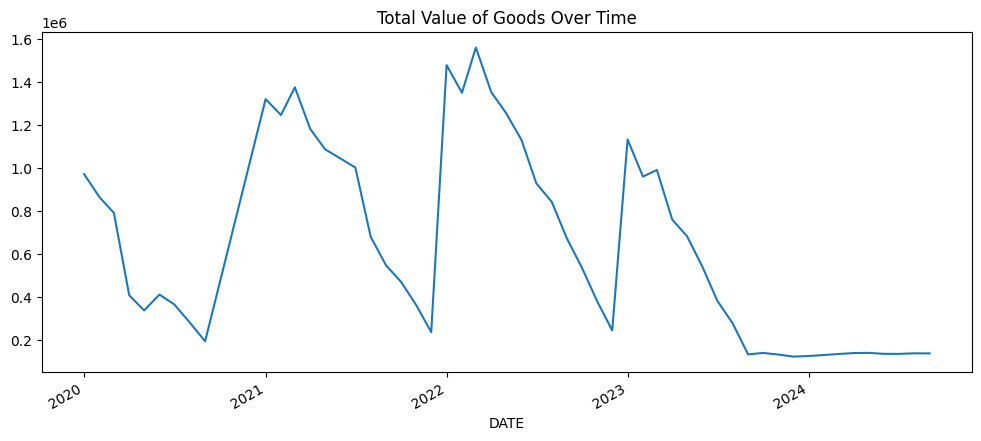

In [32]:
# Value trends over time
df.groupby('DATE')['VALUE_MILLIONS'].sum().plot(title='Total Value of Goods Over Time', figsize=(12,5))


The graph shows clear temporal trends with notable peaks around 2021-2022 and 2022-2023
Insights: The dramatic decline after 2023 maybe due to either data completeness issues(the 2024 data had lesss csv files as compared to the other years) or significant economic disruption

<Axes: title={'center': 'Freight Charges by Transport Mode'}, ylabel='TRANSPORT_MODE'>

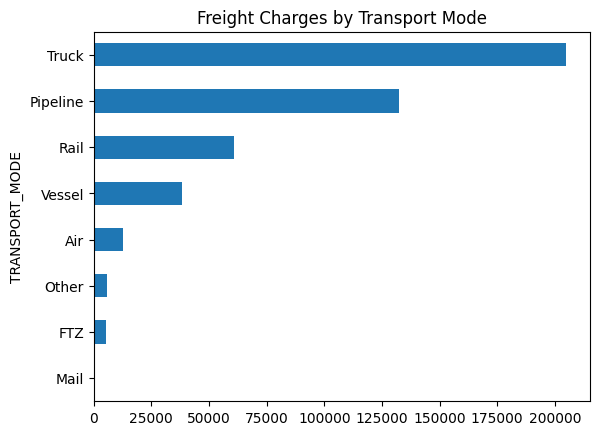

In [33]:
# Freight charges per transport mode
df.groupby('TRANSPORT_MODE')['FREIGHT_CHARGES_MILLIONS'].sum().sort_values().plot(kind='barh', title='Freight Charges by Transport Mode')


Truck significantly dominates the truck charges.

Truck > Pipeline > Rail > Vessel hierarchy is logical given infrastructure and operational costs

<Axes: title={'center': 'Container Usage'}, ylabel='count'>

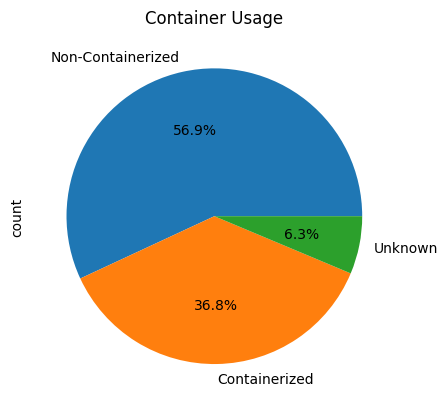

In [34]:

# Containerized vs Non-containerized
df['CONTCODE'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Container Usage')


56.9% non-containerized suggests bulk goods dominate

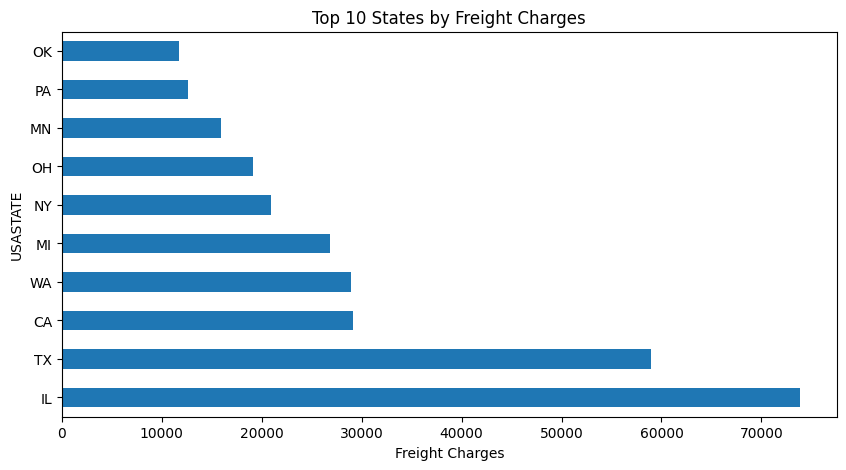

In [35]:
top_states = df.groupby('USASTATE')['FREIGHT_CHARGES_MILLIONS'].sum().nlargest(10)
top_states.plot(kind='barh', title="Top 10 States by Freight Charges", figsize=(10, 5))
plt.xlabel("Freight Charges")
plt.show()

Illinois leads significantly, followed by Texas, likely due to major transportation hubs

Text(0, 0.5, 'Total Value (USD)')

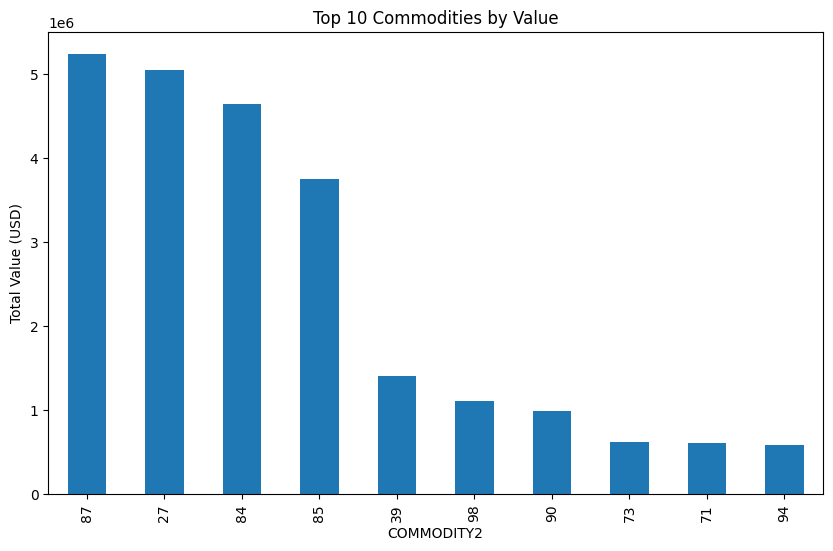

In [36]:
top_commodities = df.groupby('COMMODITY2')['VALUE_MILLIONS'].sum().sort_values(ascending=False).head(10)

top_commodities.plot(kind='bar', figsize=(10,6), title='Top 10 Commodities by Value')
plt.ylabel('Total Value (USD)')


TOP 5 COMMODITIES

Commodity 87 which denotes; Vehicles, other than railway or tramway rolling stock, and parts, dominates significantly.

The second commodity is 27 - Mineral fuels, mineral oils and products of their distillation; Bituminous substances; Mineral waxes.

The third on the list is 84 - Nuclear reactors, boilers, machinery and mechanical appliances.

The fourth is 85 - Electrical machinery and equipment and parts thereof; Sound recorders and
reproducers, television image and sound recorders and reproducers, and parts.

The last commodity on the top 5 is 39 - Plastics and articles

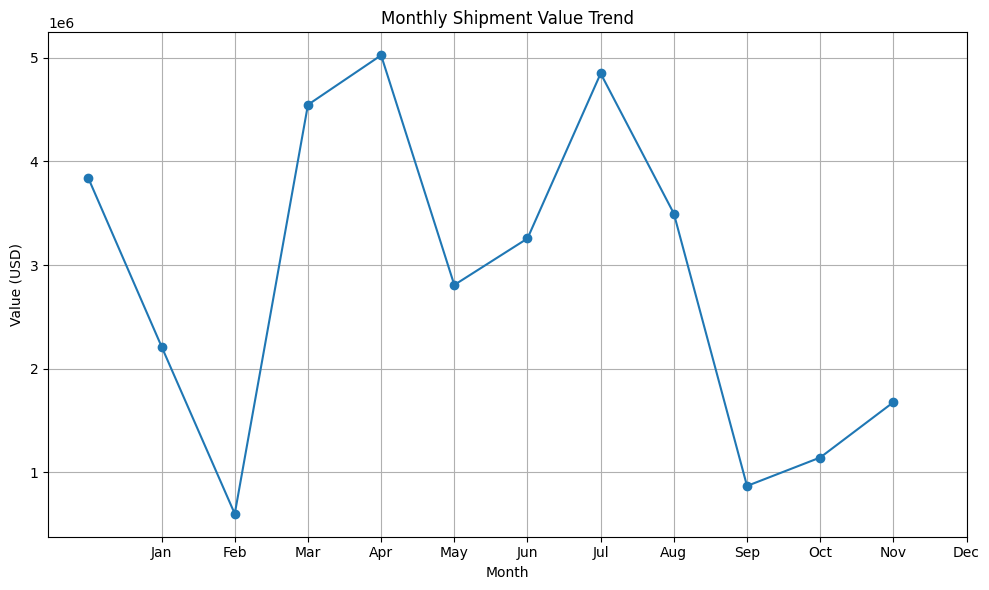

In [37]:
monthly_trend = df.groupby('MONTH_NAME')['VALUE_MILLIONS'].sum()
monthly_trend = monthly_trend.sort_index()  # ensure months are in order

monthly_trend.plot(kind='line', marker='o', title='Monthly Shipment Value Trend', figsize=(10,6))
plt.xticks(range(1, 13), calendar.month_abbr[1:])  # ['Jan', 'Feb', ..., 'Dec']
plt.xlabel("Month")
plt.ylabel("Value (USD)")
plt.grid(True)
plt.tight_layout()
plt.show()


This graph shows seasonal patterns with peaks in spring/summer; with minimum in February, maximum in April

Text(0, 0.5, 'Avg Cost per KG (USD)')

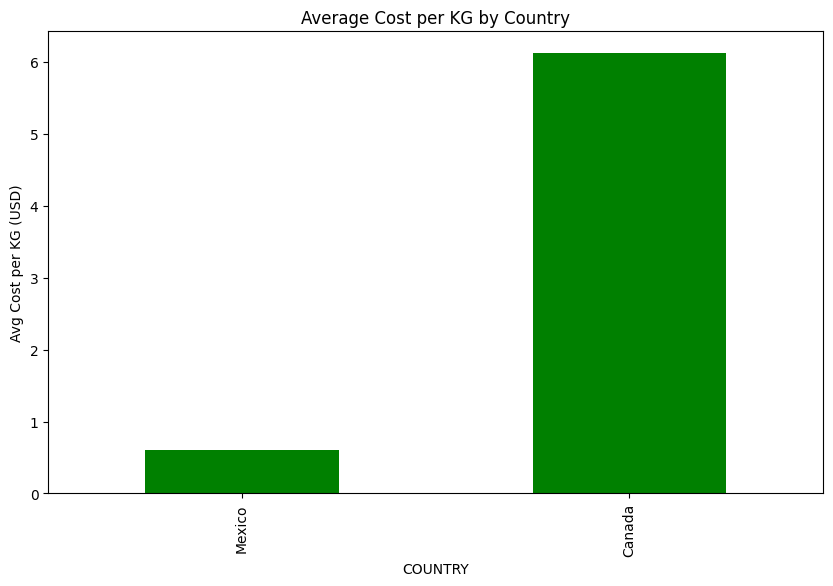

In [38]:
avg_cost_per_country = df.groupby('COUNTRY')['COST_PER_KG'].mean().sort_values()

avg_cost_per_country.plot(kind='bar', figsize=(10,6), title='Average Cost per KG by Country', color='green')
plt.ylabel('Avg Cost per KG (USD)')


Canada shows much higher cost per kg and trade value than Mexico





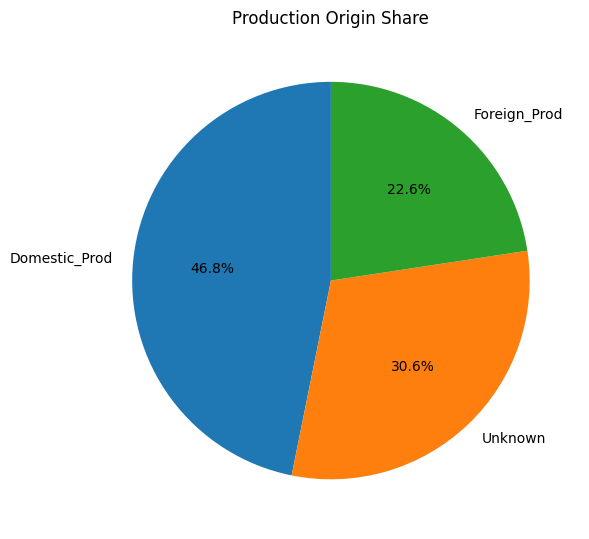

In [43]:
df['DF'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    title='Production Origin Share',
    figsize=(6, 6),
)
plt.ylabel('')
plt.tight_layout()
plt.show()

Domestic production dominates (46.8% vs 22.6% foreign). However The "Unknown" category (30.6%) is concerning which means improvement can be made at the data entry level.

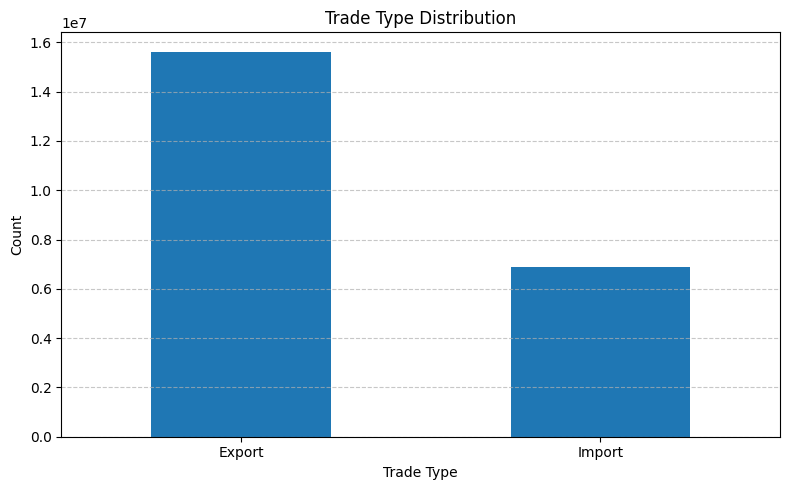

In [40]:
# TRDTYPE Distribution
df['TRDTYPE'].value_counts().plot(
    kind='bar',
    title='Trade Type Distribution',
    figsize=(8, 5)
)
plt.xlabel('Trade Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


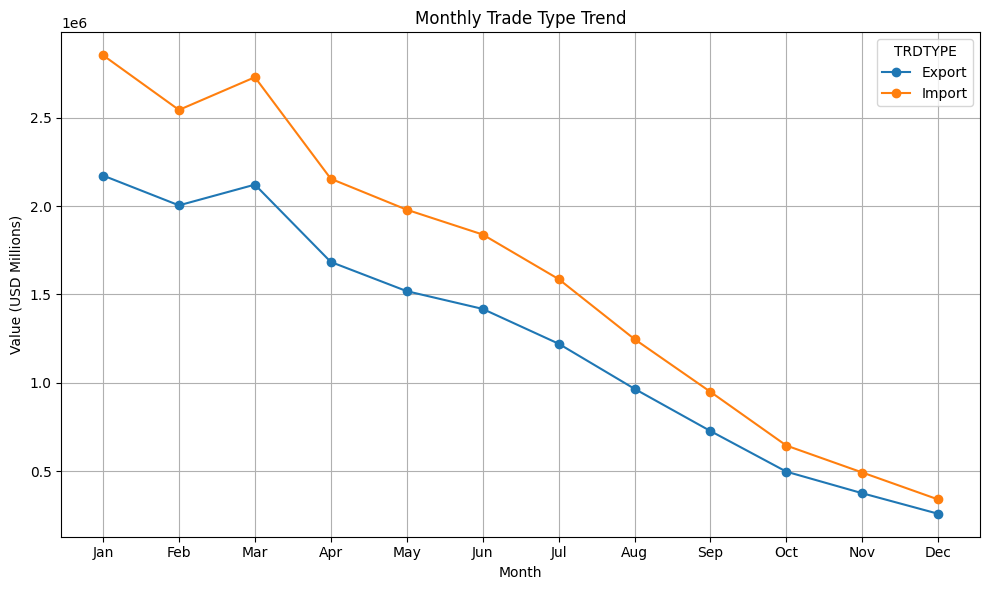

In [41]:
monthly_trend = df.groupby(['MONTH', 'TRDTYPE'])['VALUE_MILLIONS'].sum().unstack()

# Plot
monthly_trend.plot(kind='line', marker='o', title='Monthly Trade Type Trend', figsize=(10, 6))
plt.xticks(ticks=range(1, 13), labels=calendar.month_abbr[1:])
plt.xlabel("Month")
plt.ylabel("Value (USD Millions)")
plt.grid(True)
plt.tight_layout()
plt.show()

Exports significantly exceed imports; both show declining trends across the years.

#CONCLUSIONS AND RECOMMENDATIONS


### KEY CONCLUSIONS
1.   Seasonal Demand Volatility
Monthly shipment patterns show extreme seasonality with 7x variation between peak (April: ~5.0M) and trough (February: ~0.7M) periods. This volatility creates capacity utilization challenges and suggests weather-dependent or agricultural-driven trade patterns that require adaptive logistics planning.

2.   Trade Partnership Imbalances
While Canada represents 60% of trade volume, its significantly higher cost per kg ($6.0 vs Mexico's $0.8) indicates structural differences in trade composition, distances, or processing requirements. The strong export bias (2.5:1 export-import ratio) suggests healthy trade balance but potential import optimization opportunities.

3.   Transportation Infrastructure Concentration
The analysis reveals significant geographic concentration in freight handling, with Illinois and Texas dominating cross-border trade. This creates both efficiency through specialization and vulnerability through over-dependence on specific corridors. The truck-dominant transportation model (>80% of freight charges) indicates potential infrastructure strain and sustainability concerns.

4.   Critical Trade Disruption Post-2023
The dramatic decline in trade values after 2023 represents a major disruption requiring immediate attention. This pattern suggests either systemic economic changes, policy impacts, or data collection issues that fundamentally altered cross-border freight flows.


### RECOMMENDATIONS
1.   Address Data Quality Issues

* Resolve the 30.6% "unknown" production origin classifications
* Implement better data validation processes
* Establish standardized reporting protocols across all border crossings

2. Optimize Transportation Mode Mix

* Develop incentive programs to shift appropriate freight from truck to rail/pipeline
* Analyze commodity-specific modal optimization opportunities

3. Geographic Diversification Strategy

* Identify secondary freight corridors to reduce dependence on top 5 states
* Develop infrastructure investments in underutilized border crossings
* Create state/province freight distribution networks


#EXPORT CLEAN DATA AND NOTEBOOK AS HTML

In [ ]:
# save_path = '/content/drive/'

# # Save to that path
# df.to_csv(save_path, index=False)

# print(f"File saved to: {save_path}")